In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import random

GRID_SIZE = 30
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
N_ACTIONS = 5
ALPHA = 0.3
GAMMA = 0.9
EPSILON = 0.4
MAX_STEPS = 300
EPISODIOS = 20000
print("Setup listo.")

Setup listo.


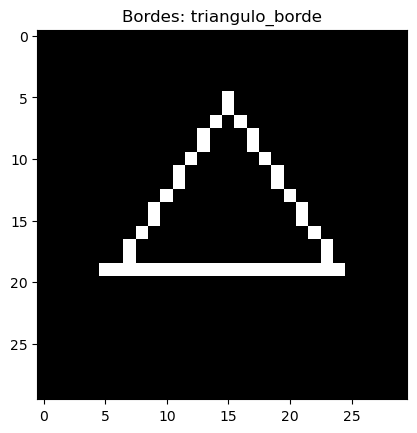

Figura: triangulo_borde


In [69]:
class Figura:
    def __init__(self, size=GRID_SIZE):
        self.size = size
        self.target = np.zeros((size, size))

    def generar_borde_circulo(self, centro=(15, 15), radio=8):
        self.target.fill(0)
        y, x = np.ogrid[:self.size, :self.size]
        mask = np.abs(np.sqrt((x - centro[1])**2 + (y - centro[0])**2) - radio) < 1
        self.target[mask] = 1
        self.nombre = 'circulo_borde'
        return self.target

    def generar_borde_cuadrado(self, topleft=(10, 10), side=10):
        self.target.fill(0)
        self.target[topleft[0]:topleft[0]+side, topleft[1]] = 1
        self.target[topleft[0]:topleft[0]+side, topleft[1]+side-1] = 1
        self.target[topleft[0], topleft[1]:topleft[1]+side] = 1
        self.target[topleft[0]+side-1, topleft[1]:topleft[1]+side] = 1
        self.nombre = 'cuadrado_borde'
        return self.target

    def generar_borde_triangulo(self, apex=(5, 15), base_width=20, height=15):  # Pico arriba, base abajo
        self.target.fill(0)
        # Pico (topo)
        self.target[apex[0], apex[1]] = 1
        # Lado izquierdo (expande hacia abajo)
        for i in range(1, height):
            x_left = apex[1] - int((base_width // 2) * (i / height))
            self.target[apex[0] + i, x_left] = 1
        # Lado derecho (expande hacia abajo)
        for i in range(1, height):
            x_right = apex[1] + int((base_width // 2) * (i / height))
            self.target[apex[0] + i, x_right] = 1
        # Base horizontal abajo
        base_y = apex[0] + height - 1
        self.target[base_y, apex[1] - base_width//2 : apex[1] + base_width//2] = 1
        self.nombre = 'triangulo_borde'
        return self.target

    def similitud(self, canvas):
        inter = np.sum(self.target * (canvas > 0))
        union = np.sum(self.target) + np.sum(canvas > 0) - inter
        return (inter / union * 100) if union > 0 else 0

    def render(self):
        plt.imshow(self.target, cmap='gray', vmin=0, vmax=1)
        plt.title(f'Bordes: {self.nombre}')
        plt.show()

fig = Figura()
fig.generar_borde_triangulo()  # Cambia manual: .generar_borde_cuadrado()
fig.render()
print(f"Figura: {fig.nombre}")

In [70]:
class Lienzo:
    def __init__(self, size=GRID_SIZE):
        self.size = size
        self.canvas = np.zeros((size, size))
        self.pos = [size // 2, size // 2]
        self.target = None
        self.target_pos = (0, 0)
        self.step_count = 0

    def reset(self):
        self.canvas = np.zeros((self.size, self.size))
        self.pos = [self.size // 2, self.size // 2]
        self.step_count = 0
        return self._get_state()

    def step(self, action, target=None):
        self.step_count += 1
        reward = -0.01

        y, x = self.pos
        in_zone = (self.target_pos[0] <= y < self.target_pos[0] + 30 and self.target_pos[1] <= x < self.target_pos[1] + 30)

        if action == 4:
            if self.canvas[y, x] == 0:
                self.canvas[y, x] = 1
                reward += 0.3  # Baja base para selectivo
                if in_zone:
                    reward += 0.2  # Nuevo: Guía a zona
                if target is not None and target.target[y, x] == 1:
                    reward += 3.0  # Sube para bordes
                else:
                    reward -= 0.8  # Más penaliza ruido
            else:
                reward -= 0.2
        else:
            dy, dx = ACTIONS[action]
            self.pos[0] = np.clip(self.pos[0] + dy, 0, self.size - 1)
            self.pos[1] = np.clip(self.pos[1] + dx, 0, self.size - 1)
            reward -= 0.05
            if in_zone:
                reward += 0.05  # Bonus move zona

        state = self._get_state()
        done = self.step_count >= MAX_STEPS
        if target is not None:
            sim = target.similitud(self.canvas)
            reward += sim / 20  # Sube peso densa
            if sim > 60:
                reward += 80  # Bono alto, threshold bajo
                done = True
        return state, reward, done

    def _get_state(self):
        sum_drawn = int(np.sum(self.canvas))
        return (int(self.pos[0]), int(self.pos[1]), sum_drawn)

    def render_comparison(self, target):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(target.target, cmap='gray')
        axs[0].set_title('Target Borde')
        axs[1].imshow(self.canvas, cmap='gray')
        axs[1].set_title(f'Agente (Pasos: {self.step_count})')
        plt.show()

In [71]:
class Agente:
    def __init__(self, n_actions=N_ACTIONS):
        self.q_table = defaultdict(lambda: np.zeros(n_actions))
        self.n_actions = n_actions

    def elegir_accion(self, state):
        if random.uniform(0, 1) < EPSILON:
            return random.randint(0, self.n_actions - 1)
        return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        # Ecuación Unida de Q-Learning (Bellman): Q(s,a) ← Q(s,a) + α [r + γ max Q(s',a') - Q(s,a)]
        best_next = np.max(self.q_table[next_state]) if not done else 0
        td_target = reward + GAMMA * best_next  # r + γ max Q(s',a')
        td_error = td_target - self.q_table[state][action]  # Error
        self.q_table[state][action] += ALPHA * td_error  # Update completo

    def guardar(self, nombre):
        with open(f'q_{nombre}.pkl', 'wb') as f:
            pickle.dump(dict(self.q_table), f)
        print(f"Guardado: q_{nombre}.pkl")

    def cargar(self, nombre):
        try:
            with open(f'q_{nombre}.pkl', 'rb') as f:
                self.q_table = defaultdict(lambda: np.zeros(self.n_actions))
                loaded = pickle.load(f)
                for k, v in loaded.items():
                    self.q_table[k] = v
            print(f"Cargado: q_{nombre}.pkl")
        except FileNotFoundError:
            print("No modelo; entrena primero.")

agente = Agente()
print("Agente listo (Q-Learning con ecuación unida).")

Agente listo (Q-Learning con ecuación unida).


Ep 0: Sim 0.0%, Pasos 300


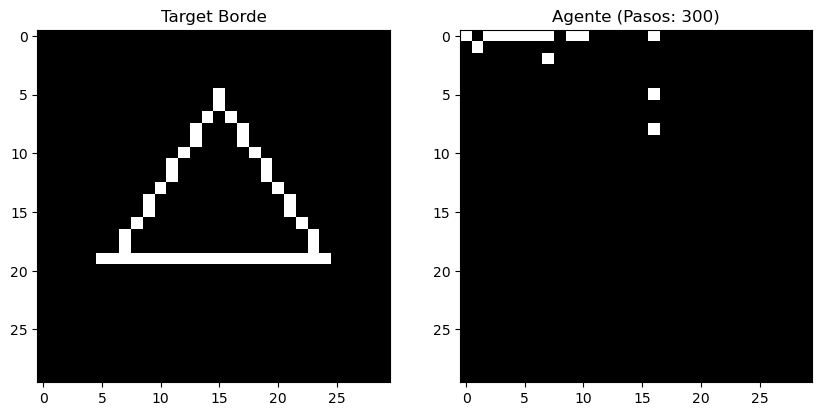

Ep 1000: Sim 23.0%, Pasos 300


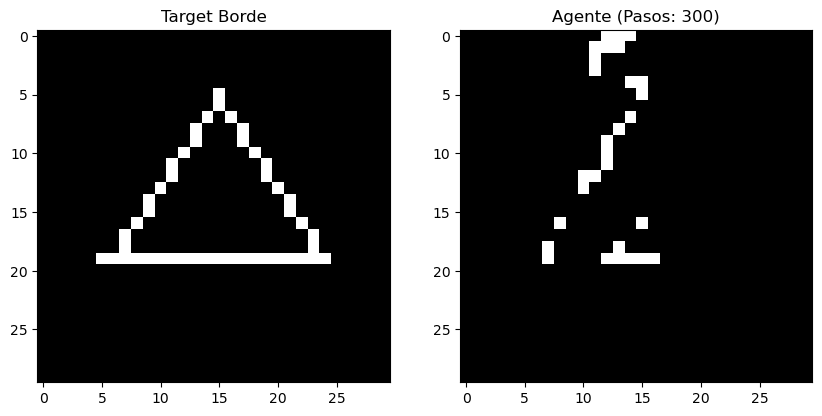

Ep 2000: Sim 28.3%, Pasos 300


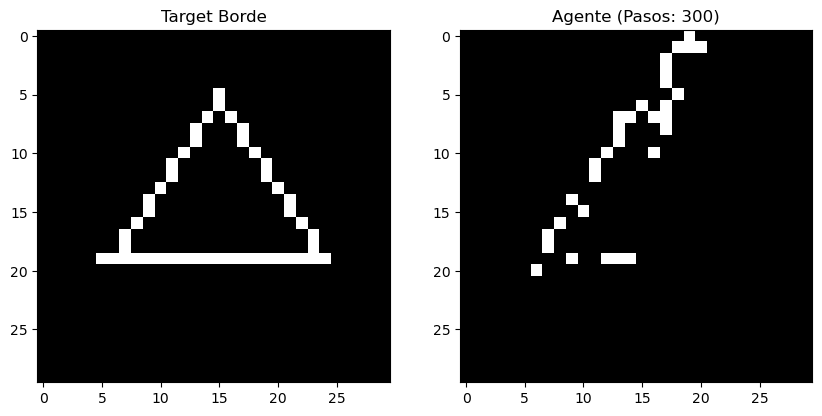

Ep 3000: Sim 28.3%, Pasos 300


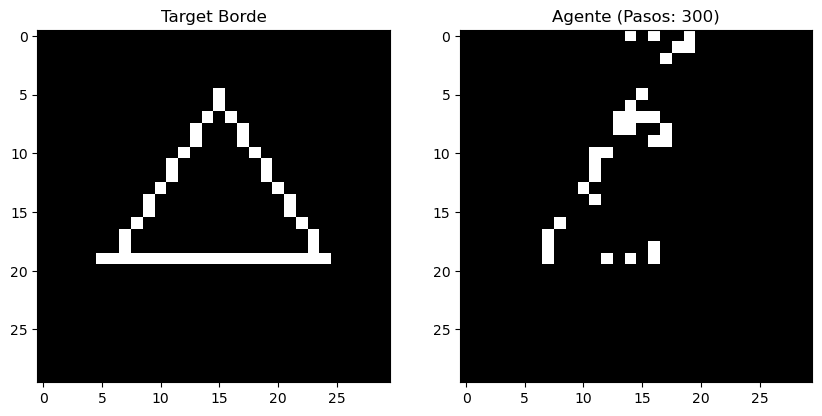

Ep 4000: Sim 27.0%, Pasos 300


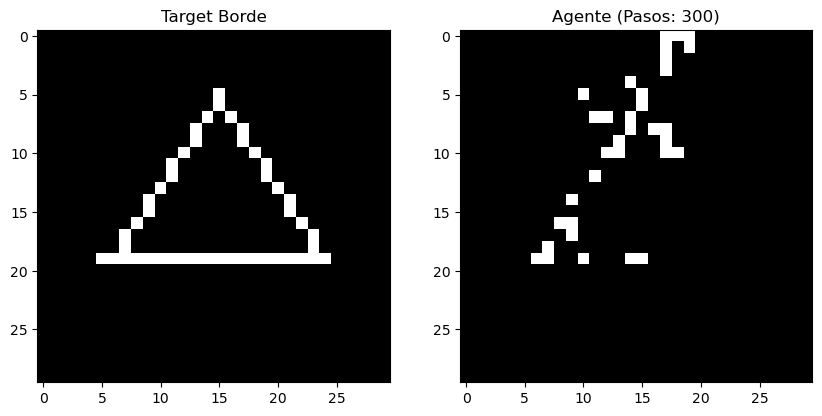

Ep 5000: Sim 25.0%, Pasos 300


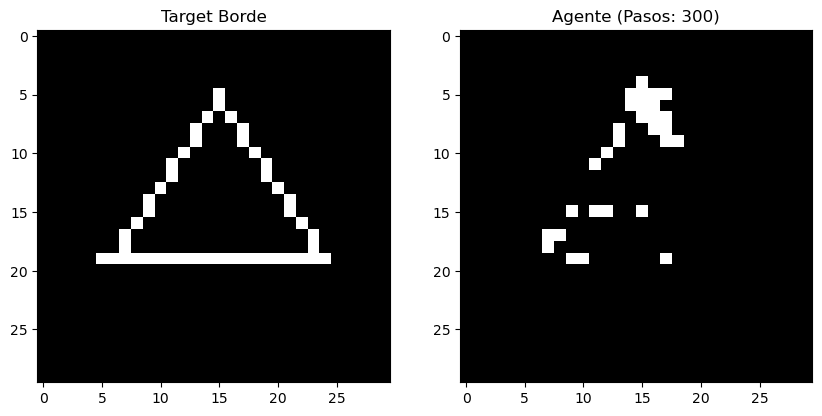

Ep 6000: Sim 34.5%, Pasos 300


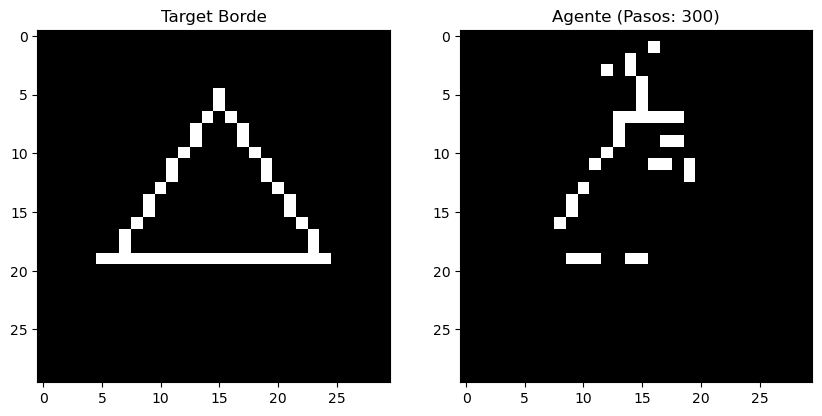

Ep 7000: Sim 26.2%, Pasos 300


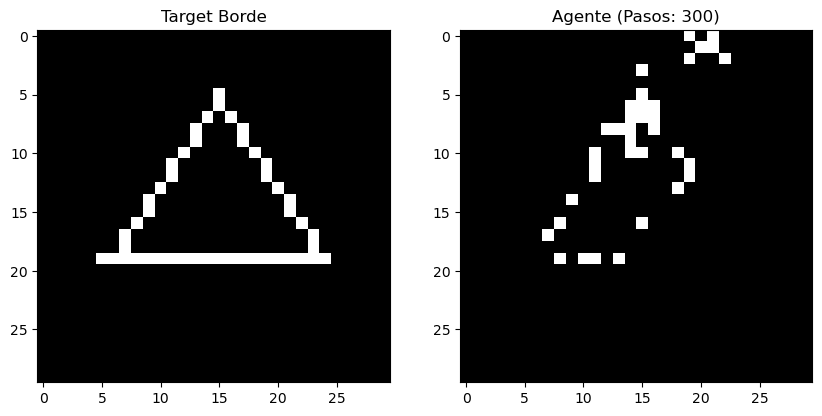

Ep 8000: Sim 31.1%, Pasos 300


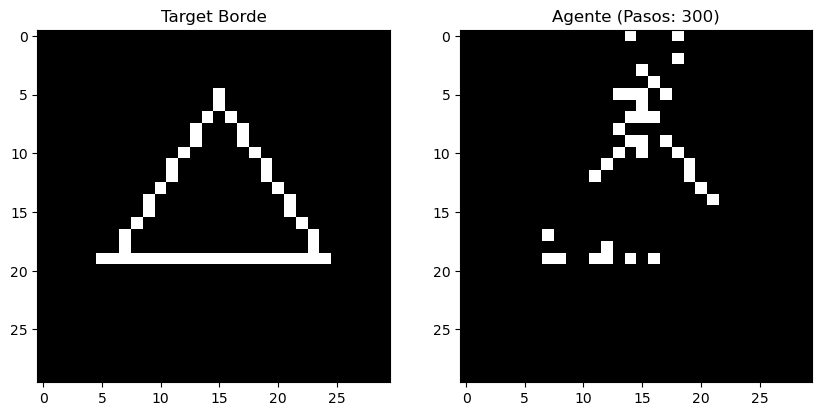

Ep 9000: Sim 28.1%, Pasos 300


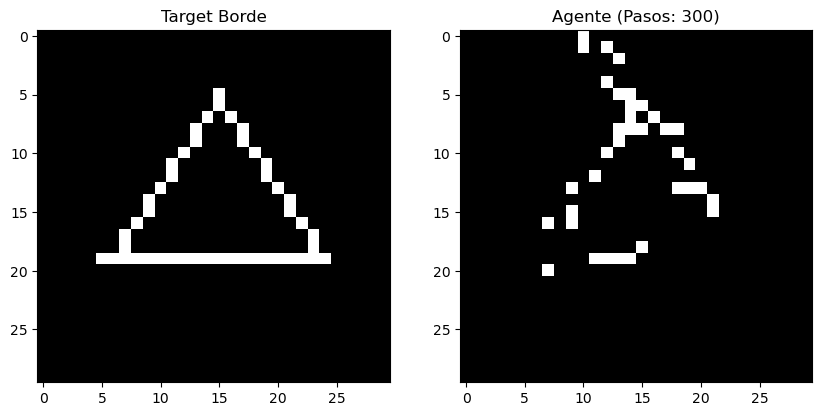

Ep 10000: Sim 24.6%, Pasos 300


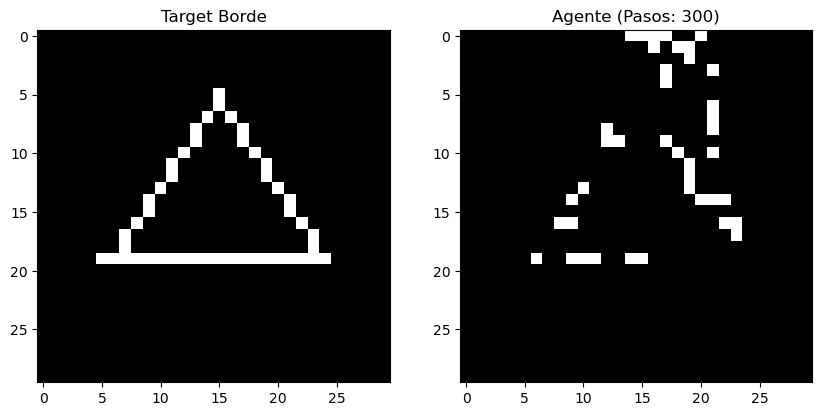

Ep 11000: Sim 31.6%, Pasos 300


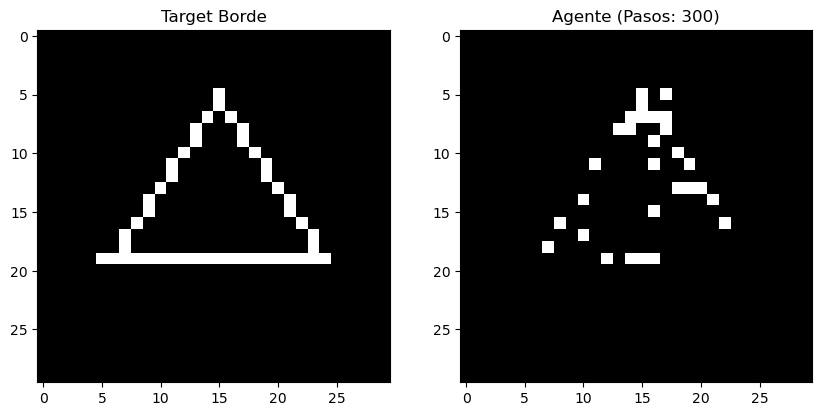

Ep 12000: Sim 37.9%, Pasos 300


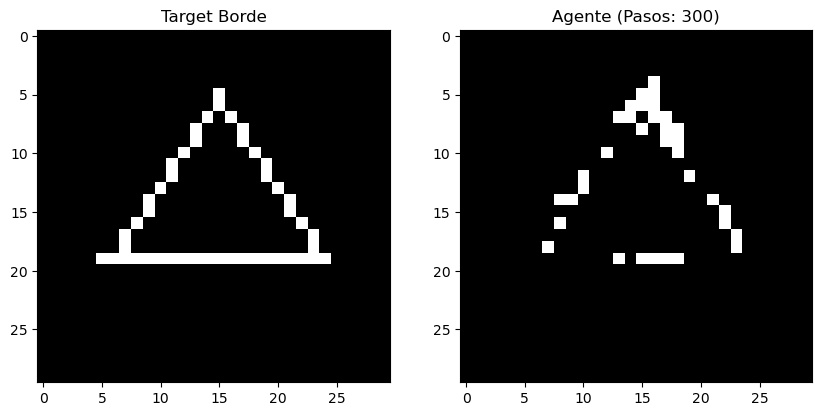

Ep 13000: Sim 38.7%, Pasos 300


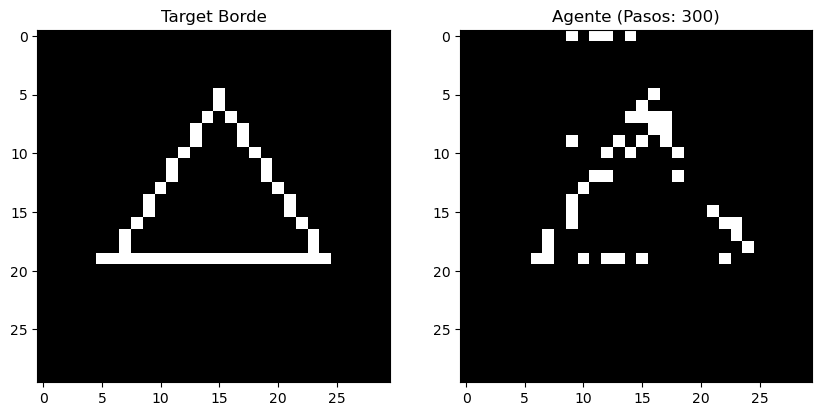

Ep 14000: Sim 35.6%, Pasos 300


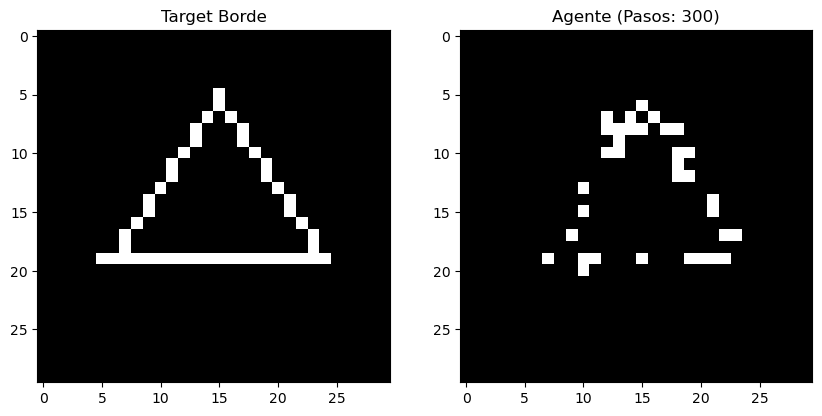

Ep 15000: Sim 34.5%, Pasos 300


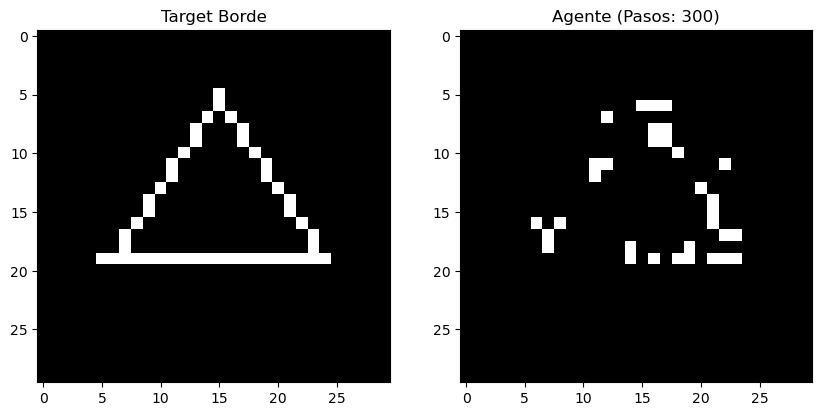

Ep 16000: Sim 46.4%, Pasos 300


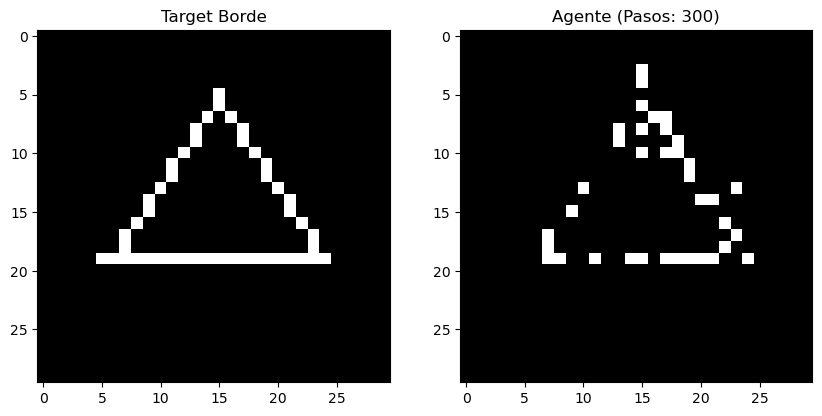

Ep 17000: Sim 42.6%, Pasos 300


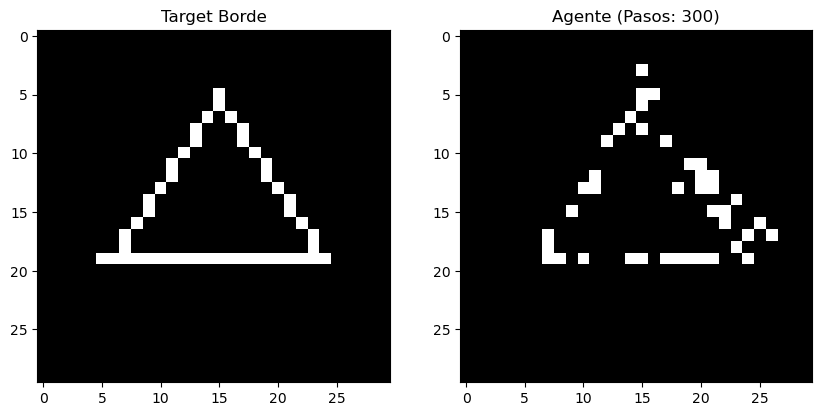

Ep 18000: Sim 33.9%, Pasos 300


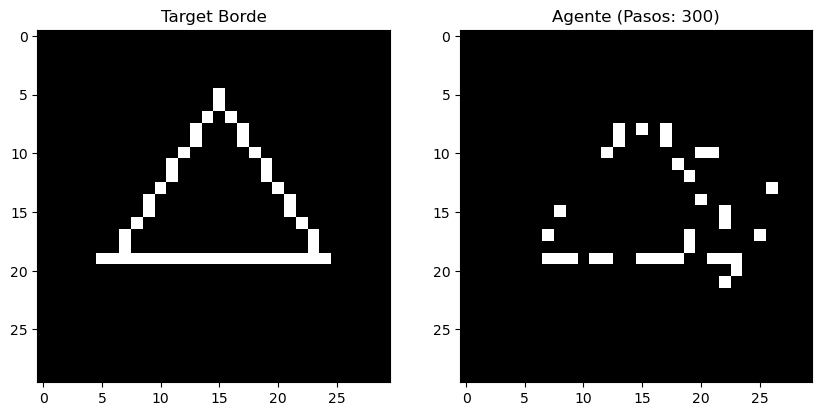

Ep 19000: Sim 43.4%, Pasos 300


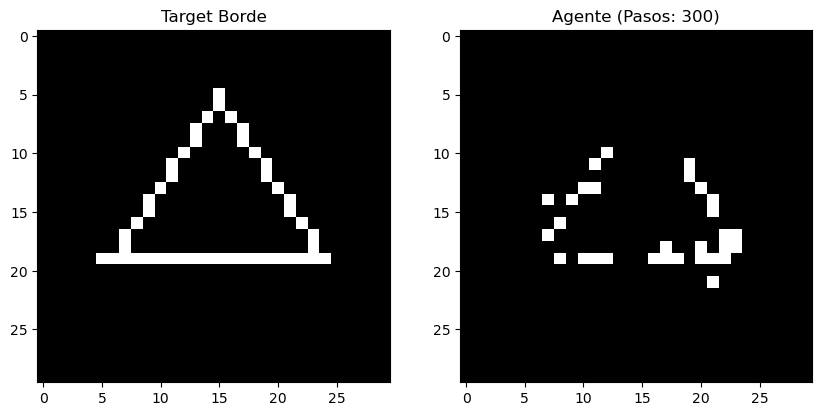

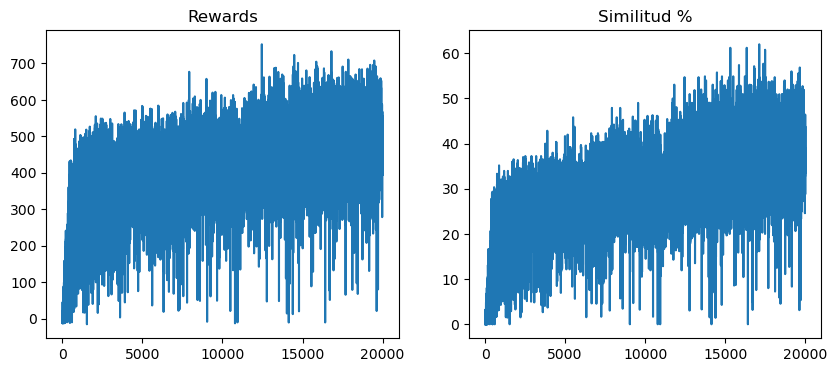

Guardado: q_triangulo_borde.pkl
triangulo_borde listo (sim 39.0%)


In [72]:
def entrenar(agente, lienzo, fig, episodios=EPISODIOS):
    rewards = []
    sims = []
    for ep in range(episodios):
        state = lienzo.reset()
        total_r = 0
        done = False
        while not done:
            action = agente.elegir_accion(state)
            next_state, r, done = lienzo.step(action, fig)
            agente.update(state, action, r, next_state, done)
            state = next_state
            total_r += r
        sim = fig.similitud(lienzo.canvas)
        rewards.append(total_r)
        sims.append(sim)
        if ep % 1000 == 0:
            print(f"Ep {ep}: Sim {sim:.1f}%, Pasos {lienzo.step_count}")
            lienzo.render_comparison(fig)
        if sim > 80:
            print(f"¡Aprendido en {ep}!")
            break
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(rewards); plt.title('Rewards')
    plt.subplot(1,2,2); plt.plot(sims); plt.title('Similitud %')
    plt.show()
    return sims[-1]

# Manual: Cambia figura
fig = Figura()
fig.generar_borde_triangulo()  # <--- CAMBIA
lienzo = Lienzo()
agente = Agente()
final_sim = entrenar(agente, lienzo, fig)
agente.guardar(fig.nombre)
print(f"{fig.nombre} listo (sim {final_sim:.1f}%)")

Cargado: q_triangulo_borde.pkl


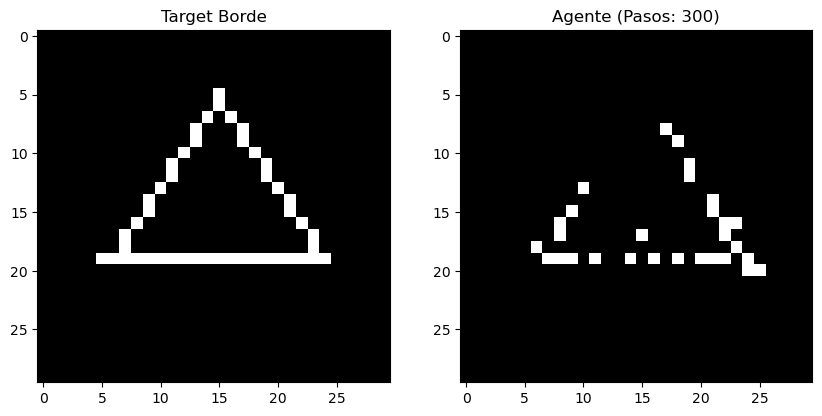

triangulo_borde: Sim 38.9%, Pasos 300


In [94]:
def dibujar_aprendida(nombre):
    agente = Agente()
    agente.cargar(nombre)
    fig = Figura()
    if 'circulo' in nombre:
        fig.generar_borde_circulo()
    elif 'cuadrado' in nombre:
        fig.generar_borde_cuadrado()
    elif 'triangulo' in nombre:
        fig.generar_borde_triangulo()
    lienzo = Lienzo()
    state = lienzo.reset()
    done = False
    while not done and lienzo.step_count < MAX_STEPS:
        action = agente.elegir_accion(state)
        next_state, _, done = lienzo.step(action, fig)
        state = next_state
    sim = fig.similitud(lienzo.canvas)
    lienzo.render_comparison(fig)
    print(f"{nombre}: Sim {sim:.1f}%, Pasos {lienzo.step_count}")

dibujar_aprendida('triangulo_borde')  # Cambia nombre

Cargado: q_cuadrado_borde.pkl
Cargado: q_triangulo_borde.pkl


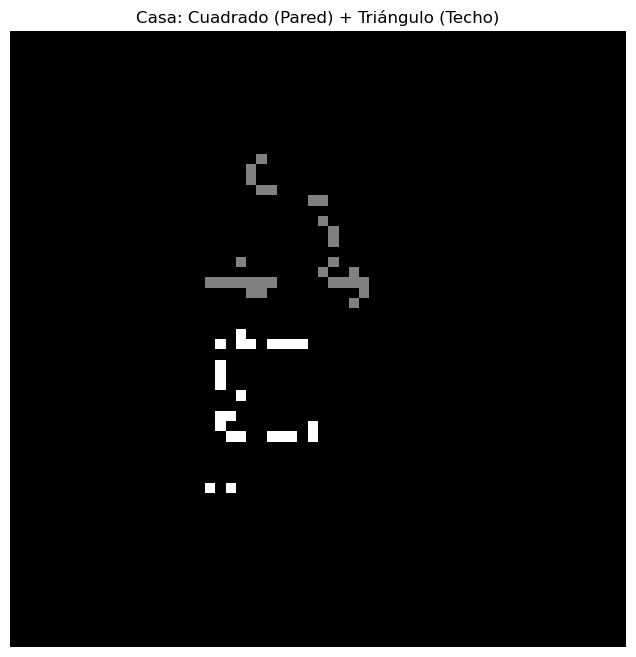

Composición generada. Ajusta offsets si superpone.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [95]:
def componer_casa():
    # Carga agentes (asumiendo entrenados)
    try:
        agente_cuad = Agente()
        agente_cuad.cargar('cuadrado_borde')
        agente_tri = Agente()
        agente_tri.cargar('triangulo_borde')
    except:
        print("Error: Entrena cuadrado_borde y triángulo_borde primero (Celda 4).")
        return None

    big_size = GRID_SIZE * 2  # Lienzo grande 60x60
    big_canvas = np.zeros((big_size, big_size))

    # Cuadrado offset (pared abajo)
    lienzo_cuad = Lienzo(GRID_SIZE)
    state = lienzo_cuad.reset()
    done_cuad = False
    for _ in range(MAX_STEPS):
        action = agente_cuad.elegir_accion(state)
        next_state, _, done_cuad = lienzo_cuad.step(action)
        state = next_state
        if done_cuad:
            break
    # Copia offset (e.g., abajo centro)
    offset_cuad = (20, 10)  # Ajusta para posición
    big_canvas[offset_cuad[0]:offset_cuad[0]+GRID_SIZE, offset_cuad[1]:offset_cuad[1]+GRID_SIZE] = lienzo_cuad.canvas

    # Triángulo offset (techo arriba del cuadrado)
    lienzo_tri = Lienzo(GRID_SIZE)
    state = lienzo_tri.reset()
    done_tri = False
    for _ in range(MAX_STEPS):
        action = agente_tri.elegir_accion(state)
        next_state, _, done_tri = lienzo_tri.step(action)
        state = next_state
        if done_tri:  # ¡Indentado correcto!
            break
    # Copia offset (arriba del cuadrado, sin superponer mucho)
    offset_tri = (5, 10)  # Pico arriba
    big_canvas[offset_tri[0]:offset_tri[0]+GRID_SIZE, offset_tri[1]:offset_tri[1]+GRID_SIZE] += lienzo_tri.canvas * 0.5  # Overlay suave

    plt.figure(figsize=(8, 8))
    plt.imshow(big_canvas, cmap='gray', vmin=0, vmax=1)
    plt.title('Casa: Cuadrado (Pared) + Triángulo (Techo)')
    plt.axis('off')
    plt.show()
    print("Composición generada. Ajusta offsets si superpone.")
    return big_canvas

# Uso
componer_casa()